<h1><center><font size="5", color='steelblue'><b>A visual example of applying scaling and standardization methods</b></font></center></h1>

<h2><center><font size="4">Using the house prices dataset</font></center></h2>


<a id='toc'></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Table of Contents</h3>

- <a href="#1">Introduction</a>
- <a href='#kde0'>Default kdeplot</a>
- <a href='#2'>Scaling with MinMaxScaler</a>
    - <a href='#kdeMinMax'> MinMaxScaler kdeplot</a>
- <a href='#3'>Scaling with StandardScaler</a>
    - <a href='#kdeStandard'> StandardScaler kdeplot</a>
- <a href='#4'>Scaling with RobustScaler</a>
    - <a href='#kdeRobustScaler'> RobustScaler kdeplot</a>
- <a href='#5'>Transformation with PowerTransformer</a>
    - <a href='#kdePowerTransformer'> PowerTransformer kdeplot</a>
- <a href='#6'>Transformation with QuantileTransformer</a>
    - <a href='#kdeQuantileTransformer'> QuantileTransformer kdeplot</a>
- <a href='#7.5'>Conclusions</a>
- <a href='#8'>Resources and further reading</a>

<a id="1"></a>
<font color="steelblue" size=+2.5><b>Introduction</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

Hello, fellow kagglers!

As a novice myself, I found it difficult to comprehend the use of scalers and transformers to preprocess the data, as I understand the idea of them and why you should use them, but not the actual transformations going behind the scenes.

That is why I decided to prepare a short kernel with the house prices dataset to use as a visual example of what scaling does to the data, both in the changes of range for each feature, and the apparent changes in their distribution, to get a sense of why transforming the data can help with the downstream modeling and predictions. I will also use Pipelines through this notebook.

Feature scaling is a necessity due to how machine learning algorithms don't perform well when numerical features follow different scales. Furthermore, they perform much better when these features follow a gaussian (also called normal) distribution.

Some things to take into account when analyzing this notebook:
* This is not a comprehensive project analysis of the house prices dataset. 
* I only worked with some continous features to show the effect of scalers/transformers of their distribution.
* Apart from data standardization/scaling, more preprocessing methodologies need to be applied to correctly prepare data for machine learning algorithmns (feature selection, feature extraction, more data exploration/visualization...)

If you want to get more behind the theory, maths, and formulas used by these scalers and transformers, there are multiple resources, from books, and kernels, to blogs on Medium. I will list some at the end of the notebook. The best resource to get hands-on it's definitely sci-kit learn's website:

* #### [Preprocessing data in sci-kit learn website](https://scikit-learn.org/stable/modules/preprocessing.html)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import plotly.express as px
py.init_notebook_mode(connected=True)

from pathlib import Path

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
df = pd.read_csv(Path("/kaggle/input/house-prices-advanced-regression-techniques/train.csv"))
df.head(5)

SEED = 42

In [3]:
# generate a table to see if there is any missing data
total_null = df.isnull().sum().sort_values(ascending=False)
percent_null = (df.isnull().sum()/df.isnull().count() * 100).sort_values(ascending=False)
nulls = pd.concat([total_null, percent_null], axis=1, keys=['total_nulls', "percent_of_nulls"])
nulls[nulls.percent_of_nulls > 0 ]

,total_nulls,percent_of_nulls
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945
GarageFinish,81,5.547945


In [4]:
to_drop = nulls[nulls.percent_of_nulls > 25].index

In [5]:
df_1 = df.drop(to_drop, axis=1)

In [6]:
set(to_drop).intersection(df_1.columns)

set()

In [7]:
cont_features = df_1.select_dtypes(include='number').columns.tolist()
print(f"there are {len(cont_features)} continous features: \n")
print(cont_features)

there are 38 continous features: 

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


                                                  Showing distribution of continous/discreate values


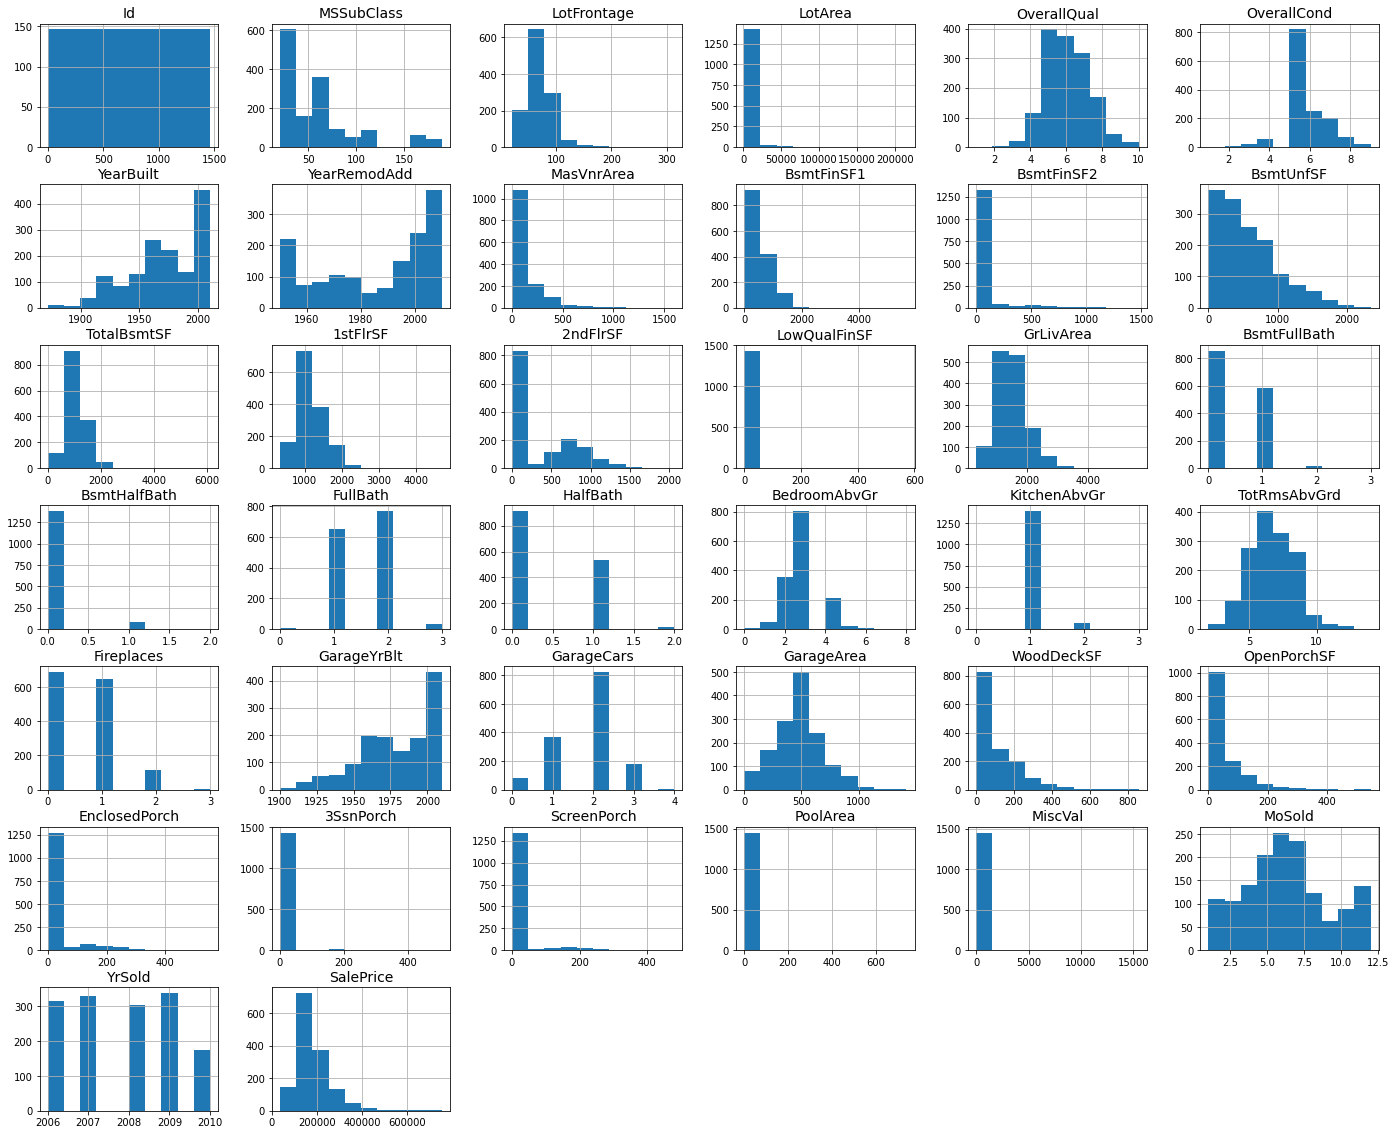

In [8]:
print(" "*50 + "Showing distribution of continous/discreate values")

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df_1[cont_features].hist(figsize=(24, 20))
plt.show()

In [9]:
selected_features = [attr for attr in cont_features if any(x in attr for x in ['SF', 'Area', 'Price' ])]
print(len(selected_features))
selected_features

15


['LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'PoolArea',
 'SalePrice']

<Figure size 432x288 with 0 Axes>

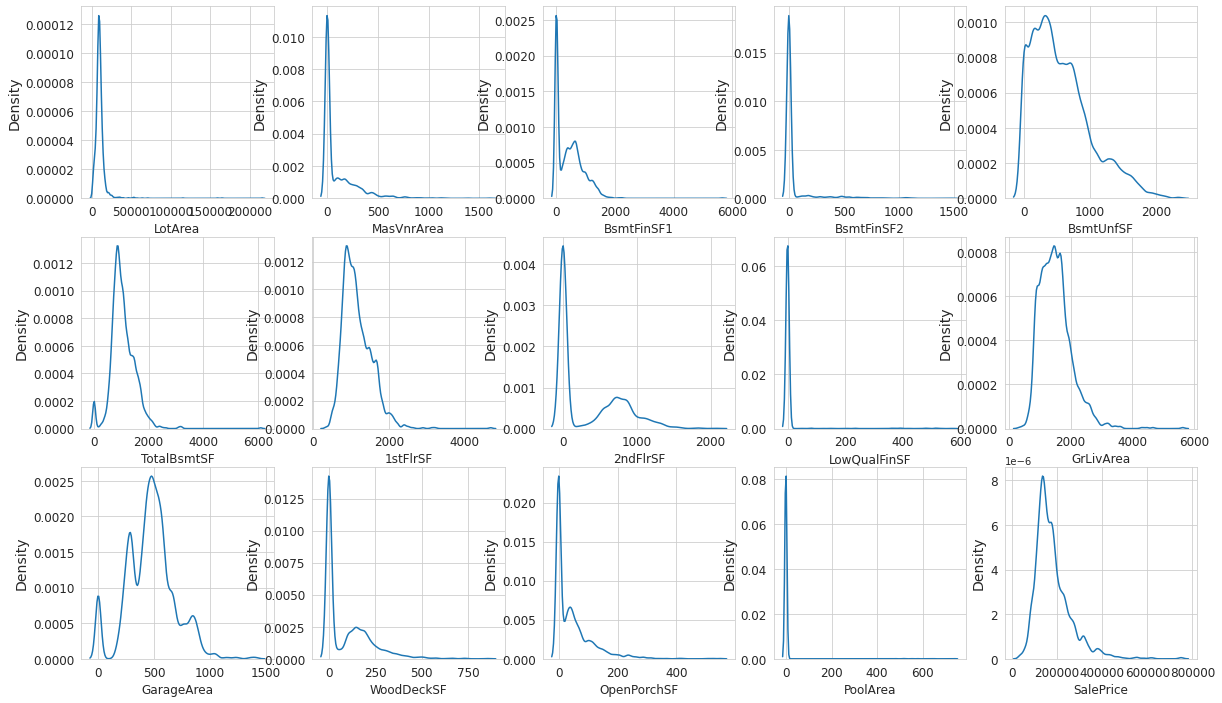

In [10]:
i = 0
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3, 5, figsize=(20, 12)) # 5 columns * 3 rows

for feature in df_1[selected_features].columns:
    i += 1
    plt.subplot(3, 5, i)
    sns.kdeplot(df_1[feature], bw_adjust=0.5)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

### <a id='kde0'><font color="steelblue" size=+1.5><b>Default kde plot</b></font></a>

Before performing any scaling or transformation, we can already observe several points from this representation:

* Most features are right-tailed, like LotArea, SalePrice, MasVnrArea...indicating that the distribution of these features are heavily affected by high outliers values
* For some features, like WoodDeckSF and OpenPorchSF, 0 is the most common value, but their distributions are not centered around it.
* For a few features, again like WoodDeckSF and OpenPorchSF, and BstmFinSF1 among others examples, present a second peak of common values


Having seen taken all of this into account, we will proceed with scaling and transforming the data and see how this changes these representations.

<a id="2"></a>
<font color="steelblue" size=+2><b>Scaling with MinMaxScaler</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

* This scaler shifts values so they fall in a specific range (default 0-1). 
* For each feature, it substracts each value in that feature by the min value of the feature and divides the result by the difference between the minimum and maximum value
* Very affected by outliers, as the algorithm will put similar values too close together while trying to leave outliers as close as possible to the minimum and maximum of the range (0 or 1, by default)   

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# We create a pipeline with the scaler
num_pipe = Pipeline(steps=[
    ('simpleImputer', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler(feature_range=(0, 1))), # we can define the range of the scaling, 
                                                   # good for neural networks, that work better with values scaled to -1, 1
])

In [12]:
# as the transformer returns a numpy array, we have to wrap it around columns and index to create a proper dataframe
df_scaled = pd.DataFrame(
    num_pipe.fit_transform(df_1[selected_features], y=None), # select numerical features for this pipe
    columns=df_1[selected_features].columns,
    index=df_1[selected_features].index,
)
df_scaled

,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,PoolArea,SalePrice
0,0.033420,0.122500,0.125089,0.000000,0.064212,0.140098,0.119780,0.413559,0.0,0.259231,0.386460,0.000000,0.111517,0.0,0.241078
1,0.038795,0.000000,0.173281,0.000000,0.121575,0.206547,0.212942,0.000000,0.0,0.174830,0.324401,0.347725,0.000000,0.0,0.203583
2,0.046507,0.101250,0.086109,0.000000,0.185788,0.150573,0.134465,0.419370,0.0,0.273549,0.428773,0.000000,0.076782,0.0,0.261908
3,0.038561,0.000000,0.038271,0.000000,0.231164,0.123732,0.143873,0.366102,0.0,0.260550,0.452750,0.000000,0.063985,0.0,0.145952
4,0.060576,0.218750,0.116052,0.000000,0.209760,0.187398,0.186095,0.509927,0.0,0.351168,0.589563,0.224037,0.153565,0.0,0.298709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.030929,0.000000,0.000000,0.000000,0.407962,0.155974,0.142038,0.336077,0.0,0.247362,0.324401,0.000000,0.073126,0.0,0.194556
1456,0.055505,0.074375,0.139972,0.110583,0.252140,0.252373,0.399036,0.000000,0.0,0.327619,0.352609,0.407235,0.000000,0.0,0.243161
1457,0.036187,0.000000,0.048724,0.000000,0.375428,0.188543,0.195961,0.557869,0.0,0.377920,0.177715,0.000000,0.109689,0.0,0.321622
1458,0.039342,0.000000,0.008682,0.698100,0.000000,0.176432,0.170721,0.000000,0.0,0.140166,0.169252,0.427071,0.000000,0.0,0.148903


In [13]:
def regression_distribution_features(df: pd.DataFrame):

    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3, 5, figsize=(20, 12)) 

    for feature in df.columns:
        i += 1
        plt.subplot(3, 5, i)
        sns.kdeplot(df[feature], bw_adjust=0.5)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();
    

<Figure size 432x288 with 0 Axes>

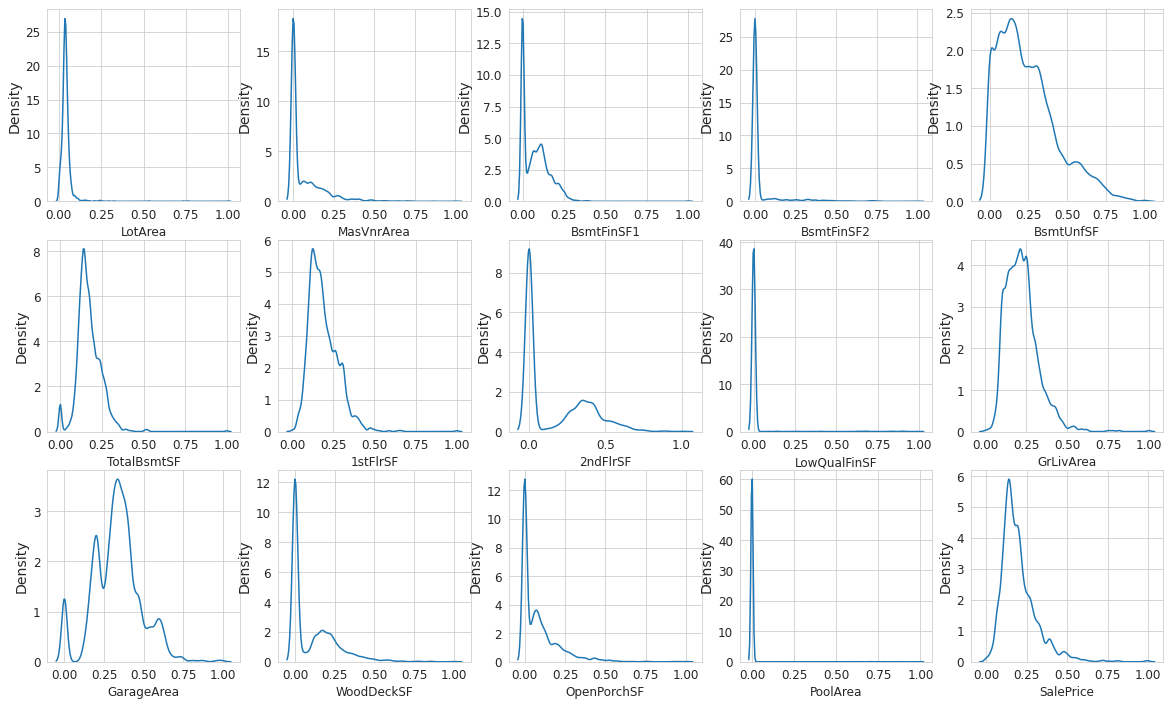

In [14]:
regression_distribution_features(df_scaled)

### <a id='kdeMinMax'><font color="steelblue" size=+1.5><b>MinMaxScaler kdeplot</b></font></a>

So, what is the result of using MinMaxScaler? Comparing it to the previous <a href='#kde0'>kdeplot with no scaling applied,</a> the distributions haven't changed, only the range of the X axis. Now, it is standard for every feature, ranging from 0-1 as we have specified in the scaler. So while the machine learning algorithms are expecting this scale for every feature, it won't help with outliers, multimodal, and heavily-tailed distributions.

<a id="3"></a>
<font color="steelblue" size=+2><b>Scaling with StandardScaler</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

* This scaler do not restrict values to an specific range, unlike MinMaxScaler.
* It works by substracting for each feature-value the mean for that feature and then dividing by the standard deviation.
* As MinMaxScaler, is not a good option for heavily-tailed distributions, like the LotArea feature from this dataset. These type of features need transformation first.

In [15]:
from sklearn.preprocessing import StandardScaler

def scale_df_pipe(df, scaler):

    num_pipe = Pipeline(steps=[
        ('simpleImputer', SimpleImputer(strategy='median')),
        ('scale', scaler), 
    ])

    df_scaled = pd.DataFrame(
        num_pipe.fit_transform(df, y=None), # select numerical features for this pipe
        columns=df.columns,
        index=df.index,
    )
    
    return df_scaled

In [16]:
df_sel = df_1[selected_features]

In [17]:
df_scaled = scale_df_pipe(df_scaled, StandardScaler())

<Figure size 432x288 with 0 Axes>

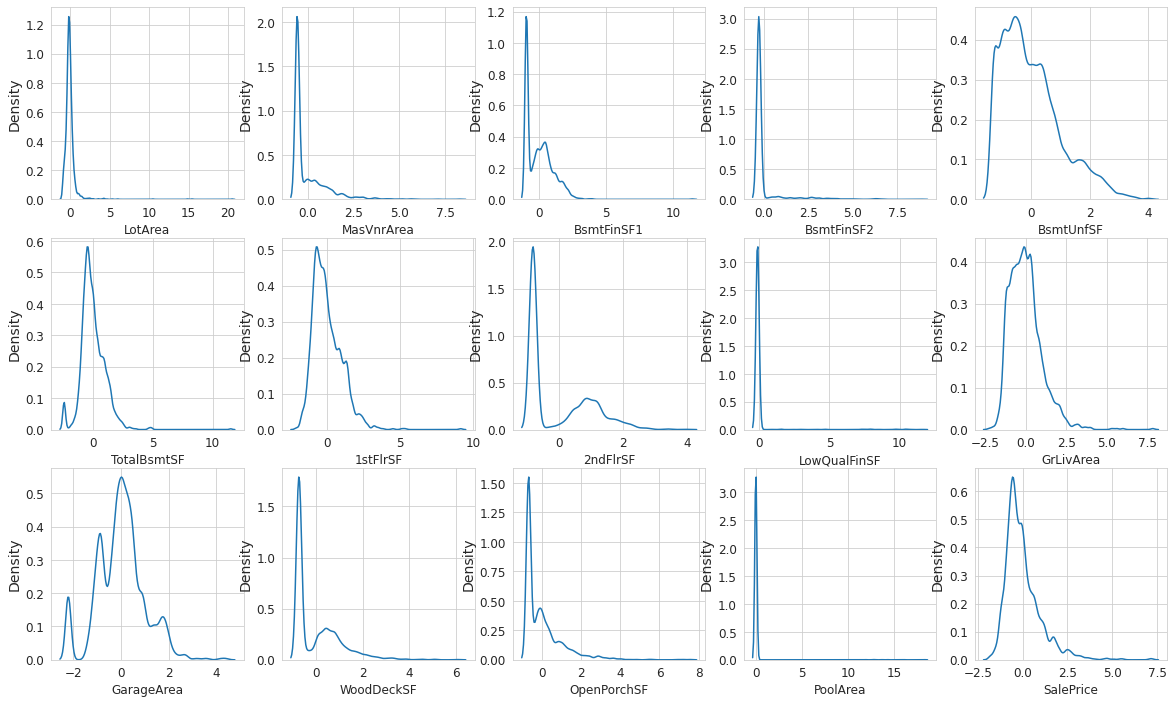

In [18]:
regression_distribution_features(df_scaled)

### <a id='kdeStandard'><font color="steelblue" size=+1.5><b>StandardScaler kdeplot</b></font></a>

Comparing StandardScaler to the <a href='#kde0'> kdeplot with no scaling applied,</a> and <a href='#kdeMinMax'> MinMaxScaler kdeplot,</a> the distributions haven't changed either, but the actual ranges are closer to the former, with different ranges for each feature. The features seem less influenced by outliers judging by the new ranges, like for the Amount feature.

<a id="4"></a>
<font color="steelblue" size=+2><b>Scaling with RobustScaler</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

* Recommended for data with many outliers
* Scales the data according to a quantile range, defaulting to the IQR, interquartile range (range between the 25th quantile and the 3rd quartile)
* Centers and scales each feature independently

<Figure size 432x288 with 0 Axes>

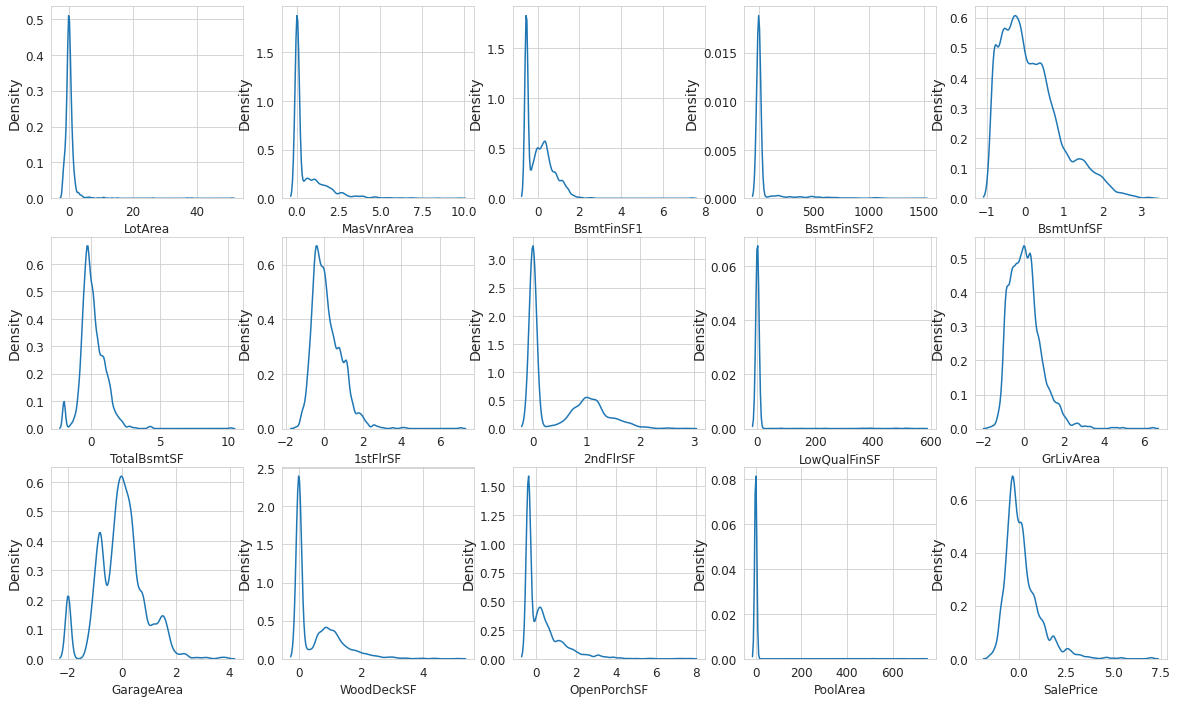

In [19]:
from sklearn.preprocessing import RobustScaler
df_scaled = scale_df_pipe(df_sel, RobustScaler())
regression_distribution_features(df_scaled)

### <a id='kdeRobustScaler'><font color="steelblue" size=+1.5><b>RobustScaler kdeplot</b></font></a>

Again, the distributions of the features have not changed, but the ranges have. In the next sections we will see how the distributions are changed with non-lineal transformers.

<a id="5"></a>
<font color="steelblue" size=+2><b>Scaling with PowerTransformer</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

* It performs non-linear transformation of the data featurewise, to try to make each feature distribution more Gaussian/normal like
* It follows up the transformation with standardization of the data, applying zero-mean, unit-variance normalization

<Figure size 432x288 with 0 Axes>

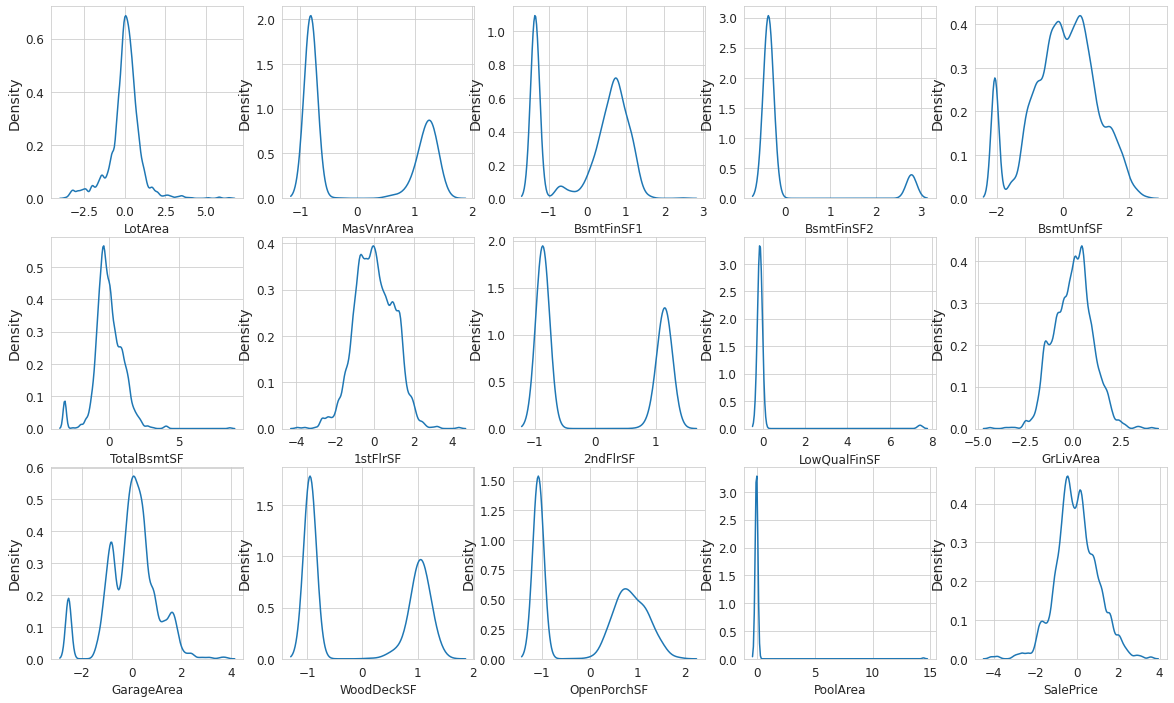

In [20]:
from sklearn.preprocessing import PowerTransformer

df_scaled = scale_df_pipe(df_sel, PowerTransformer(method='yeo-johnson'))  # by default, PowerTransformer applies standardization after transforming values
                                                                         # PowerTransformer accepts box-cox transformation for non-negative data
regression_distribution_features(df_scaled)

### <a id='kdePowerTransformer'><font color="steelblue" size=+1.5><b>PowerTransformer kdeplot</b></font></a>

* In particular, now we can appreciate how the features that presented a second peak of values have been transformed and now follow an almost bimodal distribution (WoodDeckSF, OpenPorchSF, 2ndFlrSF).
* Some right-tailed distributions, like SalePrice and LotArea, are now closer to a gaussian-like distribution

<a id="6"></a>
<font color="steelblue" size=+2><b>Scaling with QuantileTransformer</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

* Like PowerTransfomer, it transform the data to make each feature distribution more Gaussian/normal like (or following a uniform distribution, when specified)
* It tends to spread out the most frequent values while reducing the influence of outliers

<Figure size 432x288 with 0 Axes>

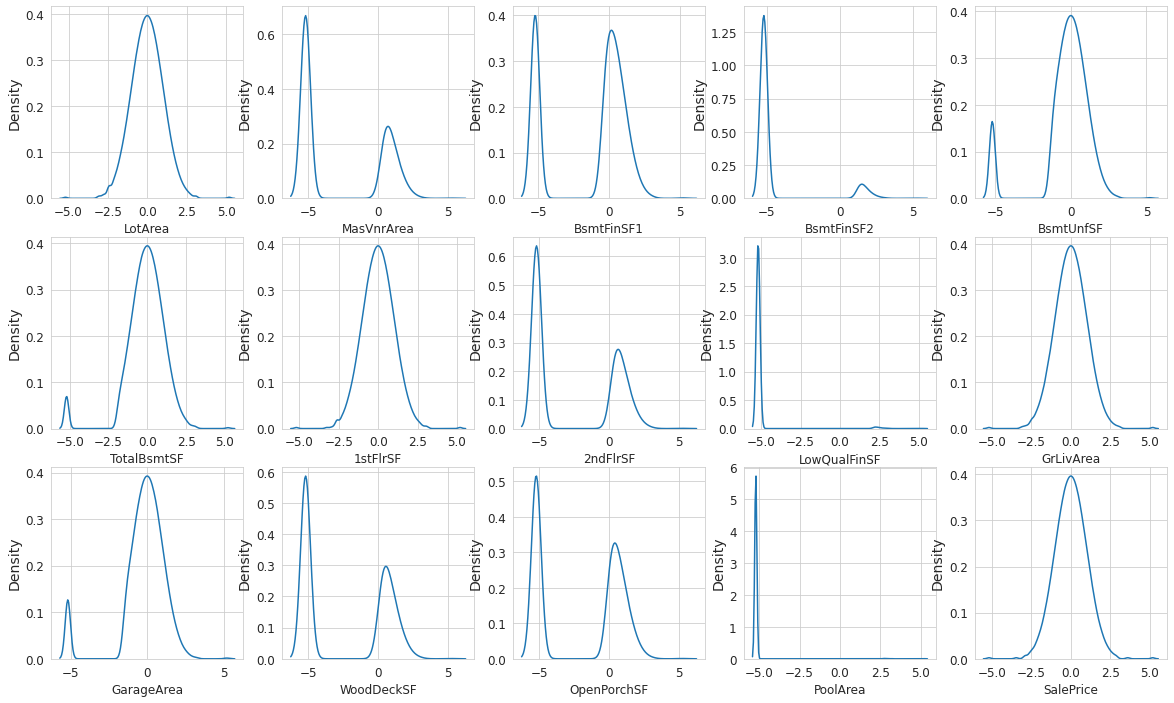

In [21]:
from sklearn.preprocessing import QuantileTransformer
df_scaled = scale_df_pipe(df_sel, QuantileTransformer(output_distribution='normal', random_state=42)) 
regression_distribution_features(df_scaled)

### <a id='kdeQuantileTransformer'><font color="steelblue" size=+1.5><b>QuantileTransformer kdeplot</b></font></a>

* Now, this is the biggest change that we have seen to our data. Almost all features present different distributions compared to <a href='#kde0'>the plot with no transformation or scaling applied</a> , and in most of them we can also see how the transformer has tried to make the data follow a normal distribution. Again, in some cases we see bimodal distributions, while neither PoolArea and LowQualFinSF present changes, which indicate that these features require of more attention and hands-on work to prepare for machine learning models, if of interest.

<a id="7.5"></a>
<font color="steelblue" size=+2><b>Conclusions</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

* We tested the effect of several scalers and transformers on some of the numerical, continuos features of the house prices dataset. 
* We studied, via kdeplot representation, how the scalers/transformers changed/rescaled the data.
* We found out how Quantile and Power transformers changed the distribution of the features the most, with the former transforming each distribution the closest to a gaussian/normal distribution.
* Some features barely changed their distribution after appliying scaling/transformers, which will require of special handling.
* To simplify the notebook, the target feature (SalePrice) was scaled together with the rest of features. To properly apply scaling, you need to drop it from the original dataframe and create training/validation sets.


If you liked this notebook/kernel, please upvote! It will encourage me to do more stuff like this while I am learning.
Of course, I am open to criticism and comments to improve the notebook. Let me know if I commited any mistake that I could fix.

Thank you for reading, and Happy learning

<a id="8"></a>
<font color="steelblue" size=+2><b>References & Further Reading</b></font>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Table of Contents</a>

* [Scikit-learn dataset transformations](https://scikit-learn.org/stable/data_transforms.html)
* [Machine learning mastery](https://machinelearningmastery.com/quantile-transforms-for-machine-learning/)
* [Machine learning friendly books post](https://www.kaggle.com/general/255972)